Le but de ce notebook est d'envisager un cas particulier : si on perd le contact avec un satellite ou que tout simplement celui-ci ne soit plus en mesure d'emettre pour la population, comment réorganiser le réseau deja existant afin de pouvoir garantir la couverture réseau ? 

Afin de résoudre ce problème, on va envisager plusieurs étapes : 
- tout d'abord on va essayer juste de trouver une solution existante avec N-1 satellites 
- par la suite, on va essayer de minimiser l'effort totale effectué par les satellites de l'état initial à l'état final, cela se fera en trouvant la disposition qui minimise la distance entre l'état initial et l'état final

In [273]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import numba
from sklearn.cluster import KMeans

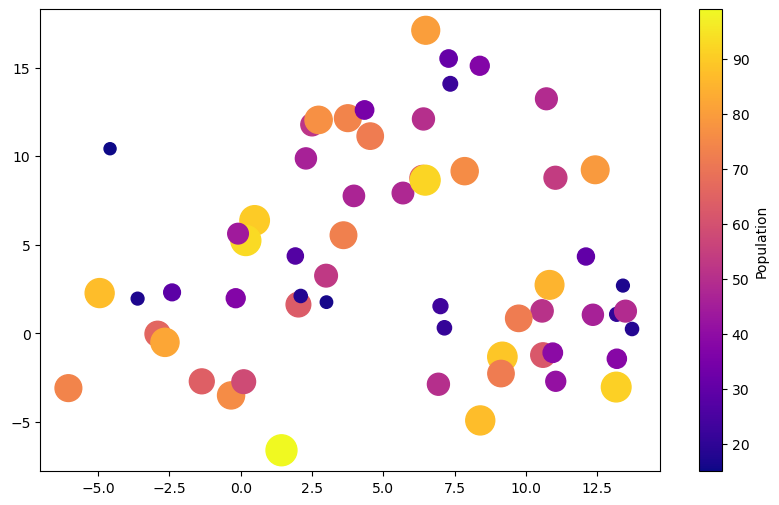

In [274]:
centers = np.array([[0, 0], [10, 0], [5, 10]])

# Générer les points à l'intérieur de chaque cluster
points_per_cluster = 20
points = []

for center in centers:
    # Générer des points aléatoires autour du centre du cluster
    cluster_points = np.random.normal(loc=center, scale=3, size=(points_per_cluster, 2))
    points.extend(cluster_points)

points = np.array(points)
xp = points[:, 0]
yp = points[:, 1]


population = np.random.randint(10, 101, size = 3*20)
size = population*5
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
sc = ax.scatter(xp, yp, c=population, cmap='plasma',
                s=size, zorder=3)
plt.colorbar(sc, label='Population')


In [275]:
Hs = 1
N = 18
n_clusters = 3
Is = 10
Imin = 0.1
ImaxSol = Imin*2

I_min_sol = 5
p = 100

In [276]:
@numba.jit(nopython = True)
def sigmoid(x, center = 0, M = 100) : 
    return 1/(1+np.exp(-M*(x-center)))

@numba.jit(nopython = True)
def pyth(x1, x2, y1, y2) : 
    return (x2-x1)**2 + (y2-y1)**2

In [299]:
x_min = np.min(xp)
x_max = np.max(xp)

y_min = np.min(yp)
y_max = np.max(yp)

@numba.jit(nopython = True, parallel = True)
def objectif(x) :
    return 10

        
    
    

@numba.jit(nopython = True, parallel = True)
def contrainte1(x) : 
    somme = 0
    for j in numba.prange(len(population)) : 
        sumj = 0
        for i in numba.prange(int(len(x)/2)) : 
            dij_sq = pyth(xp[j], x[2*i], yp[j], x[2*i+1]) + Hs**2
            sumj += Is/(dij_sq)
            
        somme += sigmoid(sumj/population[j], center = Imin, M = 1e2)*population[j]
    return somme/sum(population)




In [300]:
P = np.vstack((xp, yp)).T

kmeans = KMeans(n_clusters=n_clusters, init = "k-means++", n_init = 100)
    #n_clusters = nombre de clusters avec lequel on travaille
    #init = méthode d'initialisation des centroides, "random" ça veut dire que les centroides sont placés en mode random et "k-means++" c'est une méthode qui donne des centroides optimisés
    #n_init = nombre de fois que l'algorithme va tourner et donner la meilleure solution


kmeans.fit(P,sample_weight = population)
y_kmeans = kmeans.predict(P, sample_weight = population)

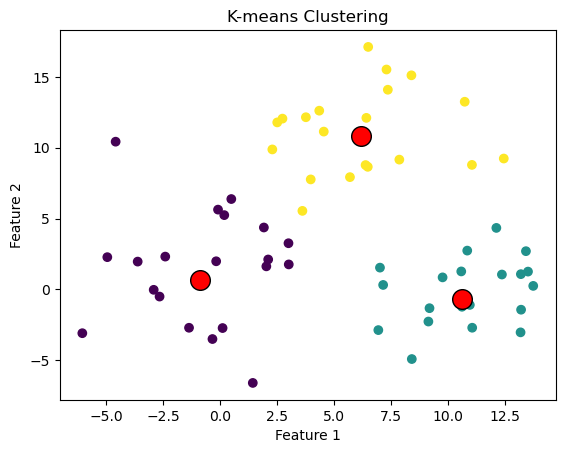

In [301]:
# Visualiser les clusters
plt.scatter(P[:, 0], P[:, 1], c=y_kmeans, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], marker='o', s=200, edgecolor='k', c='red')
plt.title('K-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [303]:
from scipy.optimize import minimize
import numba
from scipy.optimize import NonlinearConstraint, LinearConstraint
import time
import numpy as np

myc1 = NonlinearConstraint(contrainte1, 0.8, 1)
contraintes = [myc1]
centers = kmeans.cluster_centers_

centers = centers.reshape(n_clusters*2)
x0 = np.tile(centers, int(N/n_clusters))
options = {"maxiter" : 10000}


t0 = time.time()
resultat = minimize(objectif, x0, method='COBYLA', constraints = contraintes, options = options)
print("temps : ", time.time()-t0)
print(resultat)
print("Résultat de l'optimisation:", resultat.fun)
print("Valeurs optimales des variables:", resultat.x)
solution_position = resultat.x
print("Valeur de la contrainte 1 : ", contrainte1(resultat.x))

temps :  0.12955284118652344
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 10.0
       x: [-1.694e+00  1.586e+00 ...  3.133e+00  5.585e+00]
    nfev: 1666
   maxcv: 0.0
Résultat de l'optimisation: 10.0
Valeurs optimales des variables: [-1.69358119  1.58609474 10.7358561   2.52115686  4.69482156 12.22591078
 -0.73533559 -3.0660613  12.43361226  0.63170058  7.44064866  9.37831591
 -2.53155196 -0.69908052 11.09802998 -0.39426607  6.74589704 13.59979371
 -0.09973133  6.55589997  8.41121995 -4.79662453  2.62031672 11.58158176
  1.7971915   2.17541115  8.2035293  -2.31838224  5.90671361  8.68062446
  0.56381607  5.28946389  9.45520956 -0.55631062  3.13287455  5.58498259]
Valeur de la contrainte 1 :  0.8000079213474599


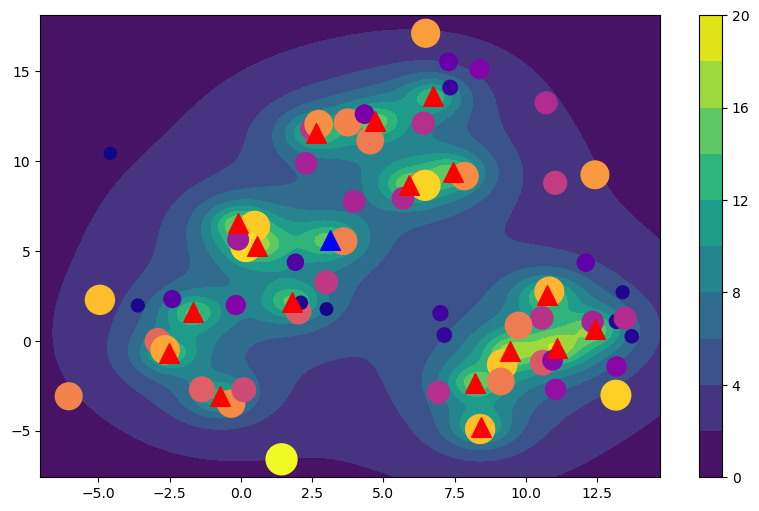

In [304]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

def f(x, y, sol):
    somme = 0
    for i in numba.prange(N) : 
        dij_sq = pyth(x, sol[2*i], y, sol[2*i+1]) + Hs**2
        somme += Is/(dij_sq) 
    return somme

# Générer des points dans le domaine [0, 1] x [0, 1]
x = np.linspace(np.min(xp)-1, np.max(xp)+1, 1000)
y = np.linspace(np.min(yp)-1, np.max(yp)+1, 1000)
X, Y = np.meshgrid(x, y)

# Calculer les valeurs de la fonction f(x, y) pour chaque point
Z = f(X, Y, resultat.x)


cf = ax.contourf(X, Y, Z, levels=10, cmap='viridis')
plt.colorbar(cf, ax = ax)
ax.scatter(xp, yp, c=population, cmap='plasma', s=size)
for i in range(N-1) : 
    ax.scatter(resultat.x[2*i], resultat.x[2*i+1], marker = "^", color = "red", s = 200, label = "sattelites")
ax.scatter(resultat.x[2*N-2], resultat.x[2*N+1-2], marker = "^", color = "blue", s = 200, label = "sattelites")

solution_position = resultat.x


On a ici repris exactement le même problème que dans S3-3. Maintenant, on va enlever un satelite et voir comment va évoluer le schéma. Le but est que dans un premier temps la couverture réseau soit maintenue. Le problème contiendra donc 2N-2 variables et aura pour conditions initiales les anciennes positions. On a mis en vert le satellite qui va disparaître.

In [305]:
from scipy.optimize import minimize
import numba
from scipy.optimize import NonlinearConstraint, LinearConstraint
import time
import numpy as np

myc1 = NonlinearConstraint(contrainte1, 0.80, 1)
contraintes = [myc1]

x0 = solution_position[:2*N-2]

options = {"maxiter" : 10000}

t0 = time.time()
resultat = minimize(objectif, x0, method='COBYLA', constraints = contraintes, options = options)
print("temps : ", time.time()-t0)
print(resultat)
print("Résultat de l'optimisation:", resultat.fun)
print("Valeurs optimales des variables:", resultat.x)
solution_position = resultat.x
print("Valeur de la contrainte 1 : ", contrainte1(resultat.x))

temps :  0.07249093055725098
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 10.0
       x: [-1.341e+00  1.596e+00 ...  9.426e+00 -4.611e-01]
    nfev: 726
   maxcv: 0.0
Résultat de l'optimisation: 10.0
Valeurs optimales des variables: [-1.34149176  1.59576456 10.72768793  2.71886824  4.80072983 11.58705955
 -0.63053493 -3.09932473 12.60494513  0.52407028  7.17676993  8.88950902
 -2.43085912 -0.5260475  10.88390092 -0.47182676  7.61678965 14.10889729
  0.50158766  5.75087495  8.36041013 -4.80626941  2.90484943 11.5237422
  2.31571847  2.658961    8.09879191 -2.1433199   5.17718691  7.49858839
  2.2316588   5.61111303  9.42558983 -0.46112876]
Valeur de la contrainte 1 :  0.8000189583942312


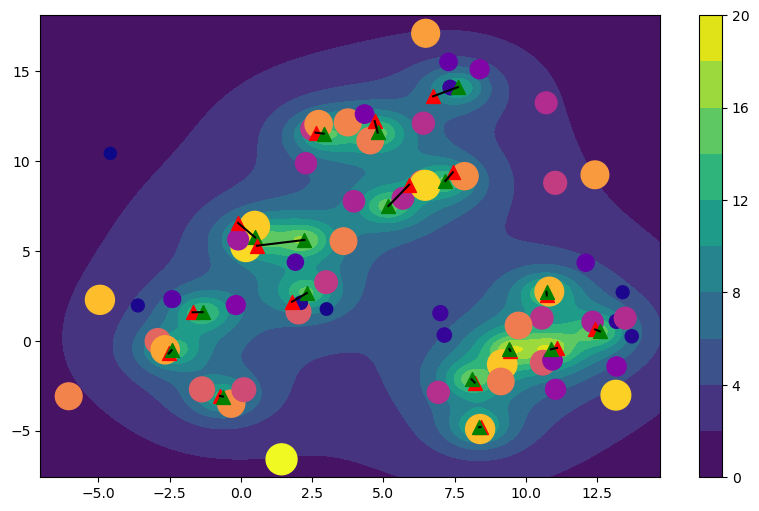

In [306]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

def f(x, y, sol):
    somme = 0
    for i in numba.prange(N-1) : 
        dij_sq = pyth(x, sol[2*i], y, sol[2*i+1]) + Hs**2
        somme += Is/(dij_sq) 
    return somme

# Générer des points dans le domaine [0, 1] x [0, 1]
x = np.linspace(np.min(xp)-1, np.max(xp)+1, 1000)
y = np.linspace(np.min(yp)-1, np.max(yp)+1, 1000)
X, Y = np.meshgrid(x, y)

# Calculer les valeurs de la fonction f(x, y) pour chaque point
Z = f(X, Y, resultat.x)


cf = ax.contourf(X, Y, Z, levels=10, cmap='viridis')
plt.colorbar(cf, ax = ax)
ax.scatter(xp, yp, c=population, cmap='plasma', s=size)
for i in range(N-1) : 
    ax.scatter(x0[2*i], x0[2*i+1], marker = "^", color = "red", s = 100, label = "old sattelites")
    ax.scatter(resultat.x[2*i], resultat.x[2*i+1], marker = "^", color = "green", s = 100, label = "new sattelites")
    ax.plot([x0[2*i], resultat.x[2*i]],[x0[2*i+1], resultat.x[2*i+1]], color = "black")

new_solution = resultat.x

#On aimerait aussi plot des lignes allant de la position initiale des satellites à la position finale


In [307]:
x_min = np.min(xp)
x_max = np.max(xp)

y_min = np.min(yp)
y_max = np.max(yp)


@numba.jit(nopython = True, parallel = True)
def objectif(x) :
    sum = 0
    for i in range(int(len(x)/2)) : 
        sum += (x[2*i] - solution_position[2*i])**2 + (x[2*i+1] - solution_position[2*i+1])**2
    return sum

        
    
    

@numba.jit(nopython = True, parallel = True)
def contrainte1(x) : 
    somme = 0
    for j in numba.prange(len(population)) : 
        sumj = 0
        for i in numba.prange(int(len(x)/2)) : 
            dij_sq = pyth(xp[j], x[2*i], yp[j], x[2*i+1]) + Hs**2
            sumj += Is/(dij_sq)
            
        somme += sigmoid(sumj/population[j], center = Imin, M = 1e2)*population[j]
    return somme/sum(population)


In [308]:
from scipy.optimize import minimize
import numba
from scipy.optimize import NonlinearConstraint, LinearConstraint
import time
import numpy as np

myc1 = NonlinearConstraint(contrainte1, 0.80, 1)
contraintes = [myc1]

x0 = solution_position[:2*N-2]

options = {"maxiter" : 10000}

t0 = time.time()
resultat = minimize(objectif, x0, method='COBYLA', constraints = contraintes, options = options)
print("temps : ", time.time()-t0)
print(resultat)
print("Résultat de l'optimisation:", resultat.fun)
print("Valeurs optimales des variables:", resultat.x)
solution_position = resultat.x
print("Valeur de la contrainte 1 : ", contrainte1(resultat.x))
new_solution = resultat.x

temps :  0.6944639682769775
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 1.0000000000045047e-08
       x: [-1.342e+00  1.596e+00 ...  9.426e+00 -4.611e-01]
    nfev: 249
   maxcv: 0.0
Résultat de l'optimisation: 1.0000000000045047e-08
Valeurs optimales des variables: [-1.34151193  1.59574472 10.72765901  2.71886383  4.80073293 11.5870644
 -0.63054377 -3.09933073 12.6049458   0.52410289  7.17679884  8.889512
 -2.43082835 -0.52606892 10.88392351 -0.47184451  7.61681348 14.10892408
  0.50158516  5.75088362  8.36040117 -4.80626264  2.90484245 11.52376903
  2.31570234  2.65896237  8.0987851  -2.14332194  5.17718306  7.49860121
  2.23162794  5.61109675  9.42559077 -0.46113796]
Valeur de la contrainte 1 :  0.8000187191333825


/Users/adammesbahi/anaconda3/lib/python3.10/site-packages/numba/core/typed_passes.py:329: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../../var/folders/g7/ns5n8gvs4pn0vkl_qlxflbkc0000gn/T/ipykernel_78966/585823227.py", line 8:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,


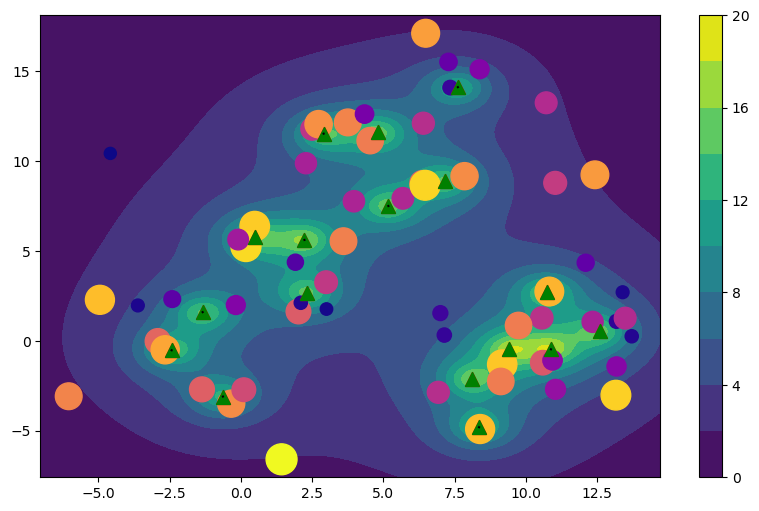

In [309]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

def f(x, y, sol):
    somme = 0
    for i in numba.prange(N-1) : 
        dij_sq = pyth(x, sol[2*i], y, sol[2*i+1]) + Hs**2
        somme += Is/(dij_sq) 
    return somme

# Générer des points dans le domaine [0, 1] x [0, 1]
x = np.linspace(np.min(xp)-1, np.max(xp)+1, 1000)
y = np.linspace(np.min(yp)-1, np.max(yp)+1, 1000)
X, Y = np.meshgrid(x, y)

# Calculer les valeurs de la fonction f(x, y) pour chaque point
Z = f(X, Y, resultat.x)


cf = ax.contourf(X, Y, Z, levels=10, cmap='viridis')
plt.colorbar(cf, ax = ax)
ax.scatter(xp, yp, c=population, cmap='plasma', s=size)
for i in range(N-1) : 
    ax.scatter(x0[2*i], x0[2*i+1], marker = "^", color = "red", s = 100, label = "old sattelites")
    ax.scatter(resultat.x[2*i], resultat.x[2*i+1], marker = "^", color = "green", s = 100, label = "new sattelites")
    ax.plot([x0[2*i], resultat.x[2*i]],[x0[2*i+1], resultat.x[2*i+1]], color = "black")

new_solution = resultat.x

#On aimerait aussi plot des lignes allant de la position initiale des satellites à la position finale


In [310]:
from scipy.optimize import minimize
import numba
from scipy.optimize import NonlinearConstraint, LinearConstraint
import time
import numpy as np

myc1 = NonlinearConstraint(contrainte1, 0.80, 1)
contraintes = [myc1]

x0 = solution_position[:2*N-4]

options = {"maxiter" : 10000}

t0 = time.time()
resultat = minimize(objectif, x0, method='COBYLA', constraints = contraintes, options = options)
print("temps : ", time.time()-t0)
print(resultat)
print("Résultat de l'optimisation:", resultat.fun)
print("Valeurs optimales des variables:", resultat.x)
solution_position = resultat.x
print("Valeur de la contrainte 1 : ", contrainte1(resultat.x))

temps :  0.3528010845184326
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 12.283020498392409
       x: [-3.062e-01  4.312e+00 ...  2.979e+00  5.632e+00]
    nfev: 5664
   maxcv: 2.681617816691073e-09
Résultat de l'optimisation: 12.283020498392409
Valeurs optimales des variables: [-0.30624941  4.31242959 10.83240533  2.44846664  4.72519164 11.75714544
 -0.61829866 -3.11981538 12.84297734  0.2098248   7.35948387  9.02455233
 -2.59242956 -0.47675684  9.79679295 -0.34196107  7.65508436 14.16503797
  0.34427833  6.02121378  8.31880637 -4.63608369  2.79563223 11.52756876
  2.28851382  2.1852093   8.53839817 -2.04918085  5.82672082  8.34938155
  2.97928471  5.63195068]
Valeur de la contrainte 1 :  0.799999997318382


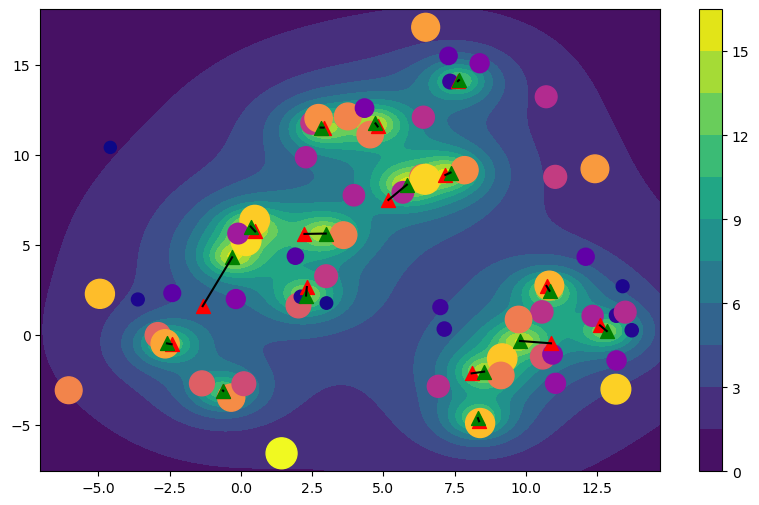

In [311]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

def f(x, y, sol):
    somme = 0
    for i in numba.prange(N-2) : 
        dij_sq = pyth(x, sol[2*i], y, sol[2*i+1]) + Hs**2
        somme += Is/(dij_sq) 
    return somme

# Générer des points dans le domaine [0, 1] x [0, 1]
x = np.linspace(np.min(xp)-1, np.max(xp)+1, 1000)
y = np.linspace(np.min(yp)-1, np.max(yp)+1, 1000)
X, Y = np.meshgrid(x, y)

# Calculer les valeurs de la fonction f(x, y) pour chaque point
Z = f(X, Y, resultat.x)


cf = ax.contourf(X, Y, Z, levels=10, cmap='viridis')
plt.colorbar(cf, ax = ax)
ax.scatter(xp, yp, c=population, cmap='plasma', s=size)
for i in range(N-2) : 
    ax.scatter(x0[2*i], x0[2*i+1], marker = "^", color = "red", s = 100, label = "old sattelites")
    ax.scatter(resultat.x[2*i], resultat.x[2*i+1], marker = "^", color = "green", s = 100, label = "new sattelites")
    ax.plot([x0[2*i], resultat.x[2*i]],[x0[2*i+1], resultat.x[2*i+1]], color = "black")

new_solution = resultat.x


In [312]:
from scipy.optimize import minimize
import numba
from scipy.optimize import NonlinearConstraint, LinearConstraint
import time
import numpy as np

myc1 = NonlinearConstraint(contrainte1, 0.80, 1)
contraintes = [myc1]

x0 = solution_position[:2*N-6]

options = {"maxiter" : 10000}

t0 = time.time()
resultat = minimize(objectif, x0, method='COBYLA', constraints = contraintes, options = options)
print("temps : ", time.time()-t0)
print(resultat)
print("Résultat de l'optimisation:", resultat.fun)
print("Valeurs optimales des variables:", resultat.x)
solution_position = resultat.x
print("Valeur de la contrainte 1 : ", contrainte1(resultat.x))

temps :  0.6009793281555176
 message: Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
 success: False
  status: 4
     fun: 28.257016094766854
       x: [ 3.317e-01  5.780e+00 ...  5.648e+00  8.232e+00]
    nfev: 8394
   maxcv: 0.010664953821477252
Résultat de l'optimisation: 28.257016094766854
Valeurs optimales des variables: [ 0.33167649  5.78015224 10.83776298  2.45735123  4.6912316  11.67029167
 -0.62298441 -3.10349225 12.84072506  0.20323112  7.29105044  8.97711523
 -2.54173602 -0.29562672  9.76397061 -0.33602191  7.62380935 14.14548871
  2.72128567  5.52204427  8.31407528 -4.62381782  2.80341014 11.4739694
  1.77951513  2.41521333  8.53152377 -2.05476126  5.64834535  8.23245135]
Valeur de la contrainte 1 :  0.7893350461785228


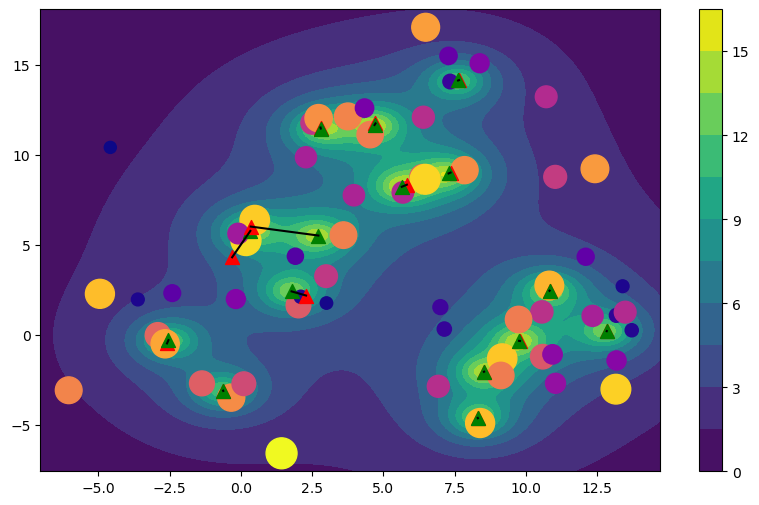

In [313]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

def f(x, y, sol):
    somme = 0
    for i in numba.prange(N-3) : 
        dij_sq = pyth(x, sol[2*i], y, sol[2*i+1]) + Hs**2
        somme += Is/(dij_sq) 
    return somme

# Générer des points dans le domaine [0, 1] x [0, 1]
x = np.linspace(np.min(xp)-1, np.max(xp)+1, 1000)
y = np.linspace(np.min(yp)-1, np.max(yp)+1, 1000)
X, Y = np.meshgrid(x, y)

# Calculer les valeurs de la fonction f(x, y) pour chaque point
Z = f(X, Y, resultat.x)


cf = ax.contourf(X, Y, Z, levels=10, cmap='viridis')
plt.colorbar(cf, ax = ax)
ax.scatter(xp, yp, c=population, cmap='plasma', s=size)
for i in range(N-3) : 
    ax.scatter(x0[2*i], x0[2*i+1], marker = "^", color = "red", s = 100, label = "old sattelites")
    ax.scatter(resultat.x[2*i], resultat.x[2*i+1], marker = "^", color = "green", s = 100, label = "new sattelites")
    ax.plot([x0[2*i], resultat.x[2*i]],[x0[2*i+1], resultat.x[2*i+1]], color = "black")

new_solution = resultat.x
